

下面的例子将展示词向量标准工具包——gensim提供的词嵌入，并展示词嵌入如何表示词的相似度。
<!-- https://nlp.stanford.edu/projects/glove/ -->

In [2]:
import numpy as np
import pprint

from gensim.models import KeyedVectors

# 从GloVe官网下载GloVe向量，此处使用的是glove.6B.zip
# 解压缩zip文件并将以下路径改为解压后对应文件的路径
model = KeyedVectors.load_word2vec_format('/your/path/here'+\
    '/glove.6B.100d.txt', binary=False, no_header=True)

In [4]:
# 使用most_similar()找到词表中距离给定词最近（最相似）的n个词
pprint.pprint(model.most_similar('film'))
pprint.pprint(model.most_similar('car'))

[('movie', 0.9055121541023254),
 ('films', 0.8914433717727661),
 ('directed', 0.8124364018440247),
 ('documentary', 0.8075793981552124),
 ('drama', 0.7929168939590454),
 ('movies', 0.7889865040779114),
 ('comedy', 0.7842751741409302),
 ('starring', 0.7573286294937134),
 ('cinema', 0.7419455647468567),
 ('hollywood', 0.7307389378547668)]
[('vehicle', 0.8630837798118591),
 ('truck', 0.8597878813743591),
 ('cars', 0.837166965007782),
 ('driver', 0.8185911178588867),
 ('driving', 0.7812635898590088),
 ('motorcycle', 0.7553157210350037),
 ('vehicles', 0.7462256550788879),
 ('parked', 0.74594646692276),
 ('bus', 0.7372707724571228),
 ('taxi', 0.7155268788337708)]


In [5]:
# 利用GloVe展示一个类比的例子
def analogy(x1, x2, y1):
    # 寻找top-N最相似的词。
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

print(analogy('china', 'chinese', 'japan'))
print(analogy('australia', 'koala', 'china'))
print(analogy('tall', 'tallest', 'long'))
print(analogy('good', 'fantastic', 'bad'))
print(analogy('man', 'woman', 'king'))

japanese
panda
longest
terrible
queen


下面将展示word2vec的代码，包括文本预处理、skipgram算法的实现、以及使用PyTorch进行优化。这里使用《小王子》这本书作为训练语料。

In [1]:
# 安装NLTK，使用如下代码下载punkt组件
#import nltk
#nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict

# 使用类管理数据对象，包括文本读取、文本预处理等
class TheLittlePrinceDataset:
    def __init__(self, tokenize=True):
        # 利用NLTK函数进行分句和分词
        text = open('the little prince.txt', 'r', encoding='utf-8').read()
        if tokenize:
            self.sentences = sent_tokenize(text.lower())
            self.tokens = [word_tokenize(sent) for sent in self.sentences]
        else:
            self.text = text

    def build_vocab(self, min_freq=1):
        # 统计词频
        frequency = defaultdict(int)
        for sentence in self.tokens:
            for token in sentence:
                frequency[token] += 1
        self.frequency = frequency

        # 加入<unk>处理未登录词，加入<pad>用于对齐变长输入进而加速
        self.token2id = {'<unk>': 1, '<pad>': 0}
        self.id2token = {1: '<unk>', 0: '<pad>'}
        for token, freq in sorted(frequency.items(), key=lambda x: -x[1]):
            # 丢弃低频词
            if freq > min_freq:
                self.token2id[token] = len(self.token2id)
                self.id2token[len(self.id2token)] = token
            else:
                break

    def get_word_distribution(self):
        distribution = np.zeros(vocab_size)
        for token, freq in self.frequency.items():
            if token in dataset.token2id:
                distribution[dataset.token2id[token]] = freq
            else:
                # 不在词表中的词按<unk>计算
                distribution[1] += freq
        distribution /= distribution.sum()
        return distribution

    # 将分词结果转化为索引表示
    def convert_tokens_to_ids(self, drop_single_word=True):
        self.token_ids = []
        for sentence in self.tokens:
            token_ids = [self.token2id.get(token, 1) for token in sentence]
            # 忽略只有一个token的序列，无法计算loss
            if len(token_ids) == 1 and drop_single_word:
                continue
            self.token_ids.append(token_ids)
        
        return self.token_ids

dataset = TheLittlePrinceDataset()
dataset.build_vocab(min_freq=1)
sentences = dataset.convert_tokens_to_ids()

In [2]:
# 遍历所有的中心词-上下文词对
window_size = 2
data = []

for sentence in sentences:
    for i in range(len(sentence)):
        for j in range(i-window_size, i+window_size+1):
            if j == i or j < 0 or j >= len(sentence):
                continue
            center_word = sentence[i]
            context_word = sentence[j]
            data.append([center_word, context_word])

# 需要提前安装numpy
import numpy as np
data = np.array(data)
print(data.shape, data)

(74374, 2) [[  4  17]
 [  4  20]
 [ 17   4]
 ...
 [131   2]
 [  2  86]
 [  2 131]]


In [3]:
# 需要提前安装PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 实现skipgram算法，使用对比学习计算损失
class SkipGramNCE(nn.Module):
    def __init__(self, vocab_size, embed_size, distribution,\
                 neg_samples=20):
        super(SkipGramNCE, self).__init__()
        print(f'vocab_size = {vocab_size}, embed_size = {embed_size}, '+\
              f'neg_samples = {neg_samples}')
        self.input_embeddings = nn.Embedding(vocab_size, embed_size)
        self.output_embeddings = nn.Embedding(vocab_size, embed_size)
        distribution = np.power(distribution, 0.75)
        distribution /= distribution.sum()
        self.distribution = torch.tensor(distribution)
        self.neg_samples = neg_samples
        
    def forward(self, input_ids, labels):
        i_embed = self.input_embeddings(input_ids)
        o_embed = self.output_embeddings(labels)
        batch_size = i_embed.size(0)
        n_words = torch.multinomial(self.distribution, batch_size * \
            self.neg_samples, replacement=True).view(batch_size, -1)
        n_embed = self.output_embeddings(n_words)
        pos_term = F.logsigmoid(torch.sum(i_embed * o_embed, dim=1))
        # 负采样，用于对比学习
        neg_term = F.logsigmoid(- torch.bmm(n_embed, \
            i_embed.unsqueeze(2)).squeeze())
        neg_term = torch.sum(neg_term, dim=1)
        loss = - torch.mean(pos_term + neg_term)
        return loss

[0.00000000e+00 4.95799942e-02 5.48904123e-02 ... 9.65530559e-05
 9.65530559e-05 9.65530559e-05]
vocab_size = 1071, embed_size = 128, neg_samples = 20


epoch-99, loss=2.8468: 100%|█| 100/100 [05:03<00:00,  3.04s/


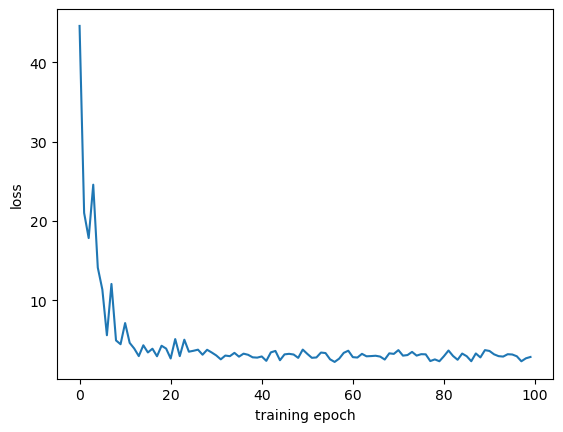

In [4]:
# 为对比学习负采样准备词频率分布
vocab_size = len(dataset.token2id)
embed_size = 128
distribution = dataset.get_word_distribution()
print(distribution)
model = SkipGramNCE(vocab_size, embed_size, distribution)

from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

# 定义静态方法collate_batch批量处理数据，转化为PyTorch可以需要的张量类型
class DataCollator:
    @classmethod
    def collate_batch(cls, batch):
        batch = np.array(batch)
        input_ids = torch.tensor(batch[:, 0], dtype=torch.long)
        labels = torch.tensor(batch[:, 1], dtype=torch.long)
        return {'input_ids': input_ids, 'labels': labels}

# 定义训练参数以及训练循环
epochs = 100
batch_size = 128
learning_rate = 1e-3
epoch_loss = []

data_collator = DataCollator()
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True,\
    collate_fn=data_collator.collate_batch)
optimizer = Adam(model.parameters(), lr=learning_rate)
model.zero_grad()
model.train()

# 需要提前安装tqdm
from tqdm import trange
import matplotlib.pyplot as plt

# 训练过程，每步读取数据，送入模型计算损失，并使用PyTorch进行优化
with trange(epochs, desc='epoch', ncols=60) as pbar:
    for epoch in pbar:
        for step, batch in enumerate(dataloader):
            loss = model(**batch)
            pbar.set_description(f'epoch-{epoch}, loss={loss.item():.4f}')
            loss.backward()
            optimizer.step()
            model.zero_grad()
        epoch_loss.append(loss.item())
    
epoch_loss = np.array(epoch_loss)
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.show()

TF-IDF加权

定义词频率（term frequency）。注意到不同长度的文章词频率会有较大差距，不利于比较和运算，因此可以对词频率取对数。

$$\text{tf}_{t,d} = \log (\text{count}(t,d) + 1)$$

其中$\text{count}(t,d)$表示词$t$在文档$d$中出现的次数，为了避免对0取对数，把所有的计数加1。

那么如何区分高频词与低频词呢？TF-IDF引入了另一个重要的评价指标——文档频率（document frequency），即一个词在语料库所包含的多少篇文档中出现。在所有文档里出现的词往往是虚词或是常见实词，而只在少量文档里出现的词往往是具有明确含义的实词并且具有很强的文档区分度。用$\text{df}_t$来表示在多少篇文档中出现了词$t$。

为了压低高频词和提升低频词的影响，TF-IDF使用文档频率的倒数，也就是逆向文档频率（inverse document frequency）来对词频率进行加权。这很好理解，一个词的文档频率越高，其倒数就越小，权重就越小。

$$\text{idf}_t = \log \frac{N}{\text{df}_t}$$

其中$N$表示文档总数。为了避免分母为0，通常会将分母改为$\text{df}_t+1$。

基于词频率和逆向文档频率，得到TF-IDF的最终值为：

$$w_{t,d} = \text{tf}_{t,d} \times \text{idf}_{t}$$


很多情况下会额外对文档的TF-IDF向量使用L2归一化，使得不同文档的TF-IDF向量具有相同的模长，便于相互比较。
下面给出了TF-IDF的代码实现。

In [5]:
class TFIDF:
    def __init__(self, vocab_size, norm='l2', smooth_idf=True,\
                 sublinear_tf=True):
        self.vocab_size = vocab_size
        self.norm = norm
        self.smooth_idf = smooth_idf
        self.sublinear_tf = sublinear_tf
    
    def fit(self, X):
        doc_freq = np.zeros(self.vocab_size, dtype=np.float64)
        for data in X:
            for token_id in set(data):
                doc_freq[token_id] += 1
        doc_freq += int(self.smooth_idf)
        n_samples = len(X) + int(self.smooth_idf)
        self.idf = np.log(n_samples / doc_freq) + 1
    
    def transform(self, X):
        assert hasattr(self, 'idf')
        term_freq = np.zeros((len(X), self.vocab_size), dtype=np.float64)
        for i, data in enumerate(X):
            for token in data:
                term_freq[i, token] += 1
        if self.sublinear_tf:
            term_freq = np.log(term_freq + 1)
        Y = term_freq * self.idf
        if self.norm:
            row_norm = (Y**2).sum(axis=1)
            row_norm[row_norm == 0] = 1
            Y /= np.sqrt(row_norm)[:, None]
        return Y
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)